In [1]:
import os
import numpy as np
import pandas as pd
import json
import pickle as cp
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
import torch
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def getScore(model,X):
    input = tf.convert_to_tensor(X)
    with tf.GradientTape() as tape:
      tape.watch(input)
      output = model(input)
    gradients = np.absolute(tape.gradient(output, input))
    init = 0
    monthly_gradients = []
    for days in mnth_days:
        mgrad = gradients[init:init+days]
        monthly_gradients.append(mgrad.sum(axis=1).sum(axis=0)/days)
        init=init+days
    monthly_gradients = np.array(monthly_gradients)

    #return monthly_gradients
    return gradients ### Returning the raw gradients instead of monthly aggregated values (temporary)

In [ ]:
def addSpanLag(data, events=[], look_back=7, look_ahead = 7, season=0,span=0):
    ### Adding span (required for weekly, monthly average data)
    if span>1:
        nts = []
        ind = 0
        while ind < len(ts):
            tmpts = ts[ind:ind+span]
            print (tmpts)
            dt = tmpts[0]
            vals = [k for k in tmpts]
            pr = sum(vals)/len(vals)
            nts.append((dt,pr))
            ind+=span
        ts = nts


    ### Adding lag (based on look back and look ahead)

    if len(events) > 0:
        input = np.append(data,events,axis=1)
    else:
        input = data
    if season>0:
        season = np.array([k%season for k in range(data.shape[0])])
        season = season.reshape(len(season),1)
        input = np.append(input,season,axis=1)


    ind = 0
    X_data = []
    y_data = []

    while ind + look_back + look_ahead < len(data):

        X = input[ind:ind+look_back]
        Y = data[ind+look_back+look_ahead]
        X_data.append(X)
        y_data.append(Y)
        ind+=1
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

In [ ]:
crops = ['Onion','Potato','Rice','Wheat']
num_top = 5
#path='/home/sunchak/projects/news_analytics/REN/'
path = '/content/drive/MyDrive/news-based-forecasting/'
event_dict = {}
for crop in crops:
  print(crop)
  model = keras.models.load_model(path+'models/onedayahead_logreturn/ren_'+crop)
  mnth_days = [31,28,31,30,31,30,31,31,30,31,30,31]*3
  #fileformat = path+'food_price_data/%s.csv'
  fileformat = path+'price_data/%s.csv'
  data = pd.read_csv(fileformat%(crop))
  price = data['price']
  dates = data['date']
  #foodpriceDf = pd.Series(food_price,index=dates)
  start_date = '2012-12-24'
  end_date = '2015-12-31'
  price.index = dates
  range_price = price[start_date:end_date]
  food_price = np.log(range_price).diff().dropna()
  price_diff = np.array(food_price).reshape(food_price.shape[0],1)


  train = np.load(path+'embeddings/events_train.npy')
  test = np.load(path+'embeddings/events_test.npy')
  events = np.append(train,test, axis=0)[2548:2548+1102]
 # print(price_diff.shape, events.shape,np.sum(range_price==0))
  X, y   = addSpanLag(price_diff,events,look_back=7,look_ahead=0,season=0)
  gradients = getScore(model,X)
  #gradients.shape
  evnt_grads = gradients[:,1:]
  top1 = []
  top10 = []
  top_events = []
  for k in range(36):
    a = evnt_grads[k]
    ind = np.argpartition(a, -num_top)[-num_top:]
    ind = np.argsort(-a)[:num_top]
    # print(ind, a[ind]*np.mean(price))
    top_events.extend(list(ind))
    top10.append(np.flip(ind))
    #top1.append(ind[-1])
    top1.append(np.argmax(a))
    print(events[:30, ind].sum(0))
    #print(ind[-1], np.argmax(a))
  event_dict[crop] = {}
  print(f'Top events = {set(top_events)}')
  for evnt in top1:
    event_dict[crop][evnt] = evnt_grads[:,evnt]
  #print(f'{crop} {event_dict[crop]}')
# cp.dump(event_dict,open(os.path.join(path,'event importance','event_scores.dict'),'wb'))

Onion
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.11813222 0.89573895]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.13744036 0.89573895 0.11813222]
[0.09671499 3.29655194 0.

ValueError: ignored

35/35 [==============================] - 1s 6ms/step
Top events for Onion = [224, 1, 164, 38, 232, 206, 207, 178, 179, 149, 215]
35/35 [==============================] - 0s 2ms/step
Top events for Potato = [224, 165, 231, 232, 206, 207, 178, 179, 211, 245, 149, 215]
35/35 [==============================] - 0s 2ms/step
Top events for Wheat = [1, 38, 232, 11, 206, 207, 178, 243, 245, 149, 215, 188]
35/35 [==============================] - 0s 4ms/step
Top events for Rice = [224, 1, 38, 232, 206, 178, 243, 179, 245, 149, 215]


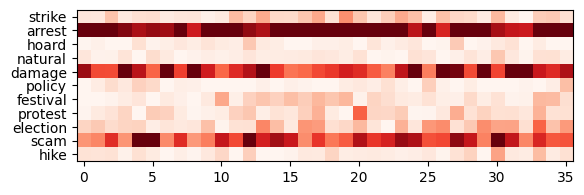

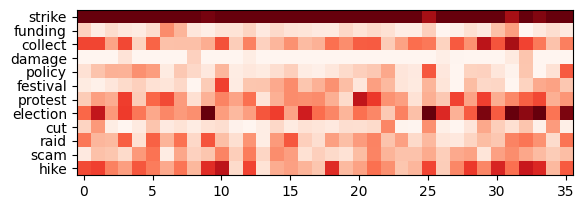

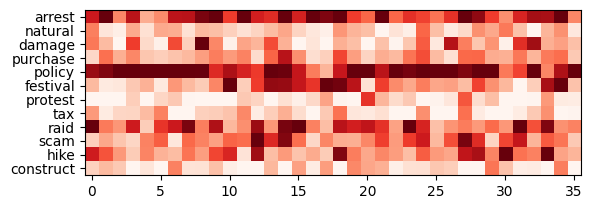

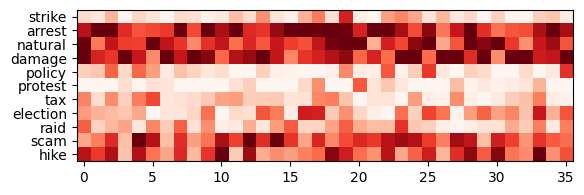

In [ ]:
#### TO run this block return raw gradients from the getScore function. This block is computing the product of event values and gradients for each day jan 2013
crops = ['Onion','Potato','Wheat','Rice']
path = '/content/drive/MyDrive/news-based-forecasting/'
event_codes = cp.load(open(path+'event_codes.dict','rb'))
mnth_days = [31,28,31,30,31,30,31,31,30,31,30,31]*3
num_top = 5
shap = True
event_dict = {}
for crop in crops:
  #if True:
  model = keras.models.load_model(path+'models/onedayahead_logreturn/ren_'+crop)
  fileformat = path+'price_data/%s.csv'
  data = pd.read_csv(fileformat%(crop))
  price = data['price']
  dates = data['date']
  #foodpriceDf = pd.Series(food_price,index=dates)
  start_date = '2012-12-24'
  end_date = '2015-12-30'
  price.index = dates
  log_prices = np.log(price).diff()[1:]
  price_start_index = 2549
  range_price = log_prices[price_start_index:price_start_index+1102]#[start_date:end_date]
  #food_price = np.log(range_price).diff()[1:]
  price_diff = np.array(range_price).reshape(range_price.shape[0],1)
  train = np.load(path+'embeddings/events_train.npy')
  test = np.load(path+'embeddings/events_test.npy')
  events = np.append(train,test, axis=0)[price_start_index+1:price_start_index+1+1102]
  mean_events = events.mean(axis=0)
  #mean_events = np.zeros(250)
  X, y   = addSpanLag(price_diff,events,look_back=7,look_ahead=0,season=0)
  num_test_preds = X.shape[0]
  test_prices = price.loc[start_date:end_date].values
  predicted_returns = np.ravel(model.predict(X))
  # print(f'returns = {predicted_returns}')
  predicted_prices = np.exp(predicted_returns)*test_prices[-num_test_preds-1:-1]
  gradients = getScore(model,X)
  gradients = gradients[:,:,1:]
  events_lagged = np.abs(X[:,:,1:] - mean_events[np.newaxis, np.newaxis, :])
  #events_lagged = predicted_prices[:, np.newaxis, np.newaxis]

  #print(X.shape,events_lagged.shape)
  #c=np.multiply(a[2557:,b)

  st = 0
  top_events = []
  for i in range(36):
    end = st+mnth_days[i]
    #print(st,end)
    c = np.multiply(gradients[st:end],events_lagged[st:end]) if shap else gradients[st:end]
    #c = c[:, [-1], :]
    # print(c.shape)
    c = (c.sum(axis=1).sum(axis=0)/mnth_days[i]).reshape(c.shape[2],1)
    top = np.argmax(c)
    topval = np.max(c,axis=1)
    #print(c.flatten())
    top_argsort = np.argsort(-c.flatten())[:num_top]
    # print(i, top, c.flatten()[top], c[:10])
    #print(top10_argsort, c.flatten()[top10_argsort])
    #for i in range(end-st):
    #ind = np.argpartition(c, -10,axis=0)[-10:]
    #top10 = np.flip(ind).flatten()
    #top10 = np.array(top10)
    top_events += list(top_argsort)
    st = end

  top_events = list(set(top_events))
  print(f'Top events for {crop} = {top_events}')
  # top_events = [1, 232, 149]
  event_vals_months = []
  st = 0
  for i in range(36):
    end = st+mnth_days[i]
    #print(st,end)
    c = np.multiply(gradients[st:end],events_lagged[st:end]) if shap else gradients[st:end]
    #c = c[:, [-1], :]
    c = (c.sum(axis=1).sum(axis=0)/mnth_days[i]).reshape(c.shape[2],1)
    top = np.argmax(c)
    # print(i, top, c.flatten()[top], c[:10])
    event_vals = []
    for k in top_events:
      #print(f'month {i}event{k} score {c[k]}')
      event_vals.append(c[k][0])
    mx = max(event_vals)
    mn = min(event_vals)
    # print(mx,mn)
    event_vals=[(val-mn)/(mx-mn) for val in event_vals]
    # print(event_vals)
    event_vals_months.append(event_vals)
    st = end

  event_vals_months = np.array(event_vals_months).T
  event_dict[crop] = {}
  for ev_id, ev in enumerate(top_events):
    event_dict[crop][event_codes[ev].upper()] = event_vals_months[ev_id]

  #print(f'event vals months = {event_vals_months}')
  # event_vals_months = event_vals_months.reshape(event_vals_months.shape[0],event_vals_months.shape[1]).T
  #print(event_vals_months.shape)
  fig, ax = plt.subplots()
  im = ax.imshow(event_vals_months,cmap=plt.colormaps["Reds"])
  top_event_names = [event_codes[ev] for ev in top_events]
  ax.set_yticks(np.arange(len(top_events)), labels=top_event_names)

cp.dump(event_dict, open(path+'event_importance_scores_shap.dict','wb'))

In [3]:
path = '/content/drive/MyDrive/news-based-forecasting/'
event_codes = cp.load(open(path+'event_codes.dict','rb'))

In [4]:
event_codes

{1: 'arrest',
 11: 'purchase',
 38: 'natural',
 149: 'scam',
 164: 'hoard',
 165: 'funding',
 178: 'protest',
 179: 'election',
 188: 'construct',
 206: 'policy',
 207: 'festival',
 211: 'cut',
 215: 'hike',
 224: 'strike',
 231: 'collect',
 232: 'damage',
 243: 'tax',
 245: 'raid'}